In [61]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from scipy import sparse
import time

import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from torch.optim.swa_utils import AveragedModel
from tqdm import tqdm

from torch_lr_finder import LRFinder

import utils
from importlib import reload

reload(utils)

IndentationError: expected an indented block (utils.py, line 472)

In [62]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('Using GPU')
else:
    device = torch.device("cpu")

Using GPU


## Files

In [63]:
DATASET = 'cite'

data_dir = '/home/artemy/multimodal_proj/data/competition/'
log_dir = '/home/artemy/multimodal_proj/cur_model_tb'
o_dir = '/home/artemy/multimodal_proj/data/AE_predictions/'


if DATASET == 'multi':
    inputs_train_fn = data_dir + "atac_train.sparse.npz"
    imputed_inputs_train_fn = data_dir + "atac_train_raw_imputed_with_scale.sparse.npz"
    targets_train_fn = data_dir + "gex_train.sparse.npz"
    inputs_test_fn = data_dir + "atac_test_raw.sparse.npz"
    imputed_inputs_test_fn = data_dir + "atac_test_raw_imputed_with_scale.sparse.npz"

    pred_file = o_dir + "multi_gex_pred.npy"
elif DATASET == 'cite':
    inputs_train_fn = data_dir + "cite_gex_train.sparse.npz"
    targets_train_fn = data_dir + "cite_adt_train.sparse.npz"
    inputs_test_fn = data_dir + "cite_gex_test.sparse.npz"
    pred_file = o_dir + "cite_adt_pred.npy"
    
    imputed_inputs_train_fn = data_dir + "cite_gex_train_magic.sparse.npz"
    imputed_inputs_test_fn = data_dir + "cite_gex_test_magic.sparse.npz"

## Model:

In [64]:
class MLP_Original_Multi(nn.Module, utils.HyperParameters):
    def __init__(self,
                 input_dim: int,
                 output_dim: int,
                 device = 'cpu',
                 **kwargs
    ):
        super().__init__()
        self.save_hyperparameters()
        
        
        modules = []
        input_dim = self.input_dim
        output_dim = 2000
        self.l1 = nn.Linear(input_dim, output_dim)
        self.bn1 = nn.BatchNorm1d(num_features=output_dim)  
        self.act1 = nn.SiLU()
        
        input_dim = output_dim
        output_dim = 2000
        self.l2 = nn.Linear(input_dim, output_dim)
        self.bn2 = nn.BatchNorm1d(num_features=output_dim)
        self.act2 = nn.SiLU()
        
        input_dim = output_dim
        output_dim = 2000
        self.l3 = nn.Linear(input_dim, output_dim)
        self.bn3 = nn.BatchNorm1d(num_features=output_dim)           
        self.act3 = nn.SiLU()
        
        input_dim = output_dim
        output_dim = 2000
        self.l4 = nn.Linear(input_dim, output_dim)
        self.bn4 = nn.BatchNorm1d(num_features=output_dim)           
        self.act4 = nn.SiLU()
        
        input_dim = output_dim
        output_dim = self.output_dim
        self.l5 = nn.Linear(input_dim, output_dim)
            
        self.net = nn.Sequential(self.l1, self.bn1, self.act1,
                                 self.l2, self.bn2, self.act2,
                                 self.l3, self.bn3, self.act3,
                                 self.l4, self.bn4, self.act4,
                                 self.l5) 
        self.net.apply(utils.init_weights)
    
    def forward(self, x):

        out = self.l1(x)
        out = self.bn1(out)
        out1 = self.act1(out)
        
        out = self.l2(out1)
        out = self.bn2(out)
        out2 = self.act2(out)
        
        out = self.l3(out2)
        out = self.bn3(out)
        out3 = self.act3(out)
        
        out = self.l4(out3)
        out = self.bn4(out)
        out4 = self.act4(out)
                        
        out = self.l5(out4)
            
        return out

In [65]:
class MLP_SVD_and_Original(nn.Module, utils.HyperParameters):
    def __init__(self,
                 input_dim: int,
                 output_dim: int,
                 n_components = 128,
                 device = 'cpu',
                 **kwargs
    ):
        super().__init__()
        self.save_hyperparameters()
        
        
        modules = []
        input_dim = self.input_dim - self.n_components
        output_dim1 = 512
        self.l1 = nn.Linear(input_dim, output_dim1)
        self.bn1 = nn.BatchNorm1d(num_features=output_dim1)  
        self.act1 = nn.SiLU()
        
        input_dim = output_dim1
        output_dim1_2 = 256
        self.l1_2 = nn.Linear(input_dim, output_dim1_2)
        self.bn1_2 = nn.BatchNorm1d(num_features=output_dim1_2)  
        self.act1_2 = nn.SiLU()
        
        input_dim = output_dim1_2 + self.n_components
        output_dim2 = 256 + self.n_components
        self.l2 = nn.Linear(input_dim, output_dim2)
        self.bn2 = nn.BatchNorm1d(num_features=output_dim2)
        self.act2 = nn.SiLU()
        
        input_dim = output_dim2
        output_dim3 = 256
        self.l3 = nn.Linear(input_dim, output_dim3)
        self.bn3 = nn.BatchNorm1d(num_features=output_dim3)           
        self.act3 = nn.SiLU()
        
        input_dim = output_dim3
        output_dim4 = 256
        self.l4 = nn.Linear(input_dim, output_dim4)
        self.bn4 = nn.BatchNorm1d(num_features=output_dim4)           
        self.act4 = nn.SiLU()
        
        input_dim = output_dim4 + output_dim3 + output_dim2
        output_dim = self.output_dim
        self.l5 = nn.Linear(input_dim, output_dim)

            
        self.net = nn.Sequential(self.l1, self.bn1, self.act1,
                                 self.l1_2, self.bn1_2, self.act1_2,
                                 self.l2, self.bn2, self.act2,
                                 self.l3, self.bn3, self.act3,
                                 self.l4, self.bn4, self.act4,
                                 self.l5)
        self.net.apply(utils.init_weights)
    
    def forward(self, x):

        out = self.l1(x[:,self.n_components:])
        out = self.bn1(out)
        out1 = self.act1(out)
        
        out = self.l1_2(out1)
        out = self.bn1_2(out)
        out1 = self.act1_2(out)
        
        out = torch.concat((x[:, :self.n_components], out1), 1)
        
        out = self.l2(out)
        out = self.bn2(out)
        out2 = self.act2(out)
        
        out = self.l3(out2)
        out = self.bn3(out)
        out3 = self.act3(out)
        
        out = self.l4(out3)
        out = self.bn4(out)
        out4 = self.act4(out)
                
        out = torch.concat((out2, out3, out4), 1)
                
        out = self.l5(out)


        return out
    
    def loss(self, y, y_hat):
        l = torch.tensor([0.], device=self.device)
        l += self.MSE_loss(y, y_hat)
        l += torch.sum(torch.abs(list(self.parameters())[0])) * 1e-2
        return l

In [66]:
class MLP_Cite_SVD(nn.Module, utils.HyperParameters):
    def __init__(self,
                 input_dim: int,
                 output_dim: int,
                 device = 'cpu',
                 **kwargs 
    ):
        super().__init__()
        self.save_hyperparameters()
        
        
        modules = []
        input_dim = self.input_dim
        output_dim1 = 512
        self.l1 = nn.Linear(input_dim, output_dim1)
        self.bn1 = nn.BatchNorm1d(num_features=output_dim1)          
        self.act1 = nn.SiLU()
        
        input_dim = output_dim1
        output_dim2 = 256 
        self.l2 = nn.Linear(input_dim, output_dim2)
        self.bn2 = nn.BatchNorm1d(num_features=output_dim2)          
        self.act2 = nn.SiLU()
        
        input_dim = output_dim2
        output_dim3 = 128 
        self.l3 = nn.Linear(input_dim, output_dim3)
        self.bn3 = nn.BatchNorm1d(num_features=output_dim3)           
        self.act3 = nn.SiLU()
        
        input_dim = output_dim3
        output_dim4 = 64 
        self.l4 = nn.Linear(input_dim, output_dim4)
        self.bn4 = nn.BatchNorm1d(num_features=output_dim4)           
        self.act4 = nn.SiLU()
        
        input_dim = output_dim1 + output_dim2 + output_dim3 + output_dim4
        output_dim5 = self.output_dim
        self.l5 = nn.Linear(input_dim, output_dim5)
        
        self.net = nn.Sequential(self.l1, self.bn1, self.act1,
                                 self.l2, self.bn2, self.act2,
                                 self.l3, self.bn3, self.act3,
                                 self.l4, self.bn4, self.act4,
                                 self.l5) 
        self.net.apply(utils.init_weights)
    
    def forward(self, x):

        out = self.l1(x)
        out = self.bn1(out)
        out1 = self.act1(out)
        
        out = self.l2(out1)
        out = self.bn2(out)
        out2 = self.act2(out)
        
        out = self.l3(out2)
        out = self.bn3(out)
        out3 = self.act3(out)
        
        out = self.l4(out3)
        out = self.bn4(out)
        out4 = self.act4(out)
        
        out = torch.concat((out1, out2, out3, out4), 1)
                
        out = self.l5(out)
        
        return out
    
    
    def loss(self, y, y_hat):
        l = torch.tensor([0.], device=self.device)
        l += self.MSE_loss(y, y_hat)
        return l

In [67]:
   
class Res_Block(nn.Module):
    def __init__(self,
                layer_sizes = [256, 256, 256]):
        super().__init__()
        self.save_hyperparameters()
        self.layers_sizes = self.layers_sizes + [sum(self.layer_sizes)]
        self.n_layers = len(self.layers_sizes) - 1
        modules = []
        for i in range(self.n_layers):
            input_dim = self.layers_sizes[i]
            output_dim = self.layers_sizes[i + 1]
            modules.append(nn.Linear(input_dim, output_dim))
            if i < self.n_layers - 1:
                modules.append(nn.BatchNorm1d(num_features=output_dim))          
                modules.append(nn.SiLU())
        self.net = nn.Sequential(*modules)
        self.net.apply(utils.init_weights)
        
    def forward(self, x):
        layer_outputs = []
        for i, module in enumerate(self.net):
            if i == len(self.net):
                x = torch.concat(layer_outputs, 1)
            x = module(x)
            layer_outputs.append(x)
            if isinstance(module, nn.SiLU):
                layer_outputs.append(x)
                
        return x

In [68]:
class Universal_Model(nn.Module, utils.HyperParameters):
    def __init__(self,
                 input_dim: int,
                 output_dim: int,
                 layers_sizes = [512] * 4,
                 concat_pos = 4,
                 n_of_layers_to_concat = 3,
                 dropout = 1,
                 device = 'cpu',
                 **kwargs 
    ):
        super().__init__()
        self.save_hyperparameters()
        self.layers_sizes = [self.input_dim] + self.layers_sizes + [self.output_dim]
        self.n_layers = len(self.layers_sizes) - 1
        modules = []
        for i in range(self.n_layers):
            if i != self.concat_pos:
                input_dim = self.layers_sizes[i]
            else:
                input_dim = sum(self.layers_sizes[self.concat_pos-self.n_of_layers_to_concat+1:self.concat_pos+1])
            output_dim = self.layers_sizes[i + 1]
            if i < self.n_layers and dropout != 1:
                modules.append(nn.Dropout1d(dropout))
            modules.append(nn.Linear(input_dim, output_dim))
            if i < self.n_layers - 1:
                modules.append(nn.BatchNorm1d(num_features=output_dim))          
                modules.append(nn.SiLU())
        self.net = nn.Sequential(*modules)
        self.net.apply(utils.init_weights)
    
    def forward(self, x):
        fc_layer_n = 0
        layer_outputs = []
        for module in self.net:
            if fc_layer_n == self.concat_pos and isinstance(module, nn.Linear):
                x = torch.concat(layer_outputs[-self.n_of_layers_to_concat:], 1)
            x = module(x)
            if isinstance(module, nn.SiLU):
                layer_outputs.append(x)
            if isinstance(module, nn.Linear):
                fc_layer_n += 1
        return x

## Load data

In [54]:
load_data = 1
use_imputed_data = 1
if load_data:
    inputs = utils.load_sparse_data(inputs_train_fn)
    targets = utils.load_sparse_data(targets_train_fn)
    inputs_test = utils.load_sparse_data(inputs_test_fn)
    if use_imputed_data:
        imputed_inputs = utils.load_sparse_data(imputed_inputs_train_fn)
        imputed_inputs_test = utils.load_sparse_data(imputed_inputs_test_fn)

In [55]:
from sklearn.decomposition import TruncatedSVD, NMF, PCA, KernelPCA

batch_size = 2048
num_workers = 1
do_svd = True


if not do_svd:
    inputs_processed = imputed_inputs
    inputs_test_processed = imputed_inputs_test
elif DATASET == 'cite':
    
    n_components = 48
    use_svd = 1
    if use_svd:
        svd =  TruncatedSVD(n_components=n_components, random_state=1)
    else:
        svd = umap.UMAP(n_components=n_components)
        
    inputs_combined = np.concatenate((inputs, inputs_test))
    inputs_combined = svd.fit_transform(inputs_combined)
    inputs_svd = inputs_combined[:len(inputs)]
    inputs_test_svd = inputs_combined[-len(inputs_test):]
    
    use_imputed = 1
    if use_imputed:
        rna_levels = imputed_inputs
        rna_levels_test = imputed_inputs_test
    else:
        rna_levels = inputs
        rna_levels_test = inputs_test
        
    only_important_genes = 1
    if only_important_genes:
        cite_inputs_features = pd.read_csv(data_dir + 'cite_inputs_features.csv').iloc[:, 0].tolist()
        important_cols = ['ENSG00000114013_CD86', 'ENSG00000120217_CD274', 'ENSG00000196776_CD47', 'ENSG00000117091_CD48', 'ENSG00000101017_CD40', 'ENSG00000102245_CD40LG', 'ENSG00000169442_CD52', 'ENSG00000117528_ABCD3', 'ENSG00000168014_C2CD3', 'ENSG00000167851_CD300A', 'ENSG00000167850_CD300C', 'ENSG00000186407_CD300E', 'ENSG00000178789_CD300LB', 'ENSG00000186074_CD300LF', 'ENSG00000241399_CD302', 'ENSG00000167775_CD320', 'ENSG00000105383_CD33', 'ENSG00000174059_CD34', 'ENSG00000135218_CD36', 'ENSG00000104894_CD37', 'ENSG00000004468_CD38', 'ENSG00000167286_CD3D', 'ENSG00000198851_CD3E', 'ENSG00000117877_CD3EAP', 'ENSG00000074696_HACD3', 'ENSG00000015676_NUDCD3', 'ENSG00000161714_PLCD3', 'ENSG00000132300_PTCD3', 'ENSG00000082014_SMARCD3', 'ENSG00000121594_CD80', 'ENSG00000110651_CD81', 'ENSG00000238184_CD81-AS1', 'ENSG00000085117_CD82', 'ENSG00000112149_CD83', 'ENSG00000066294_CD84', 'ENSG00000114013_CD86', 'ENSG00000172116_CD8B', 'ENSG00000254126_CD8B2', 'ENSG00000177455_CD19', 'ENSG00000105383_CD33', 'ENSG00000173762_CD7', 'ENSG00000125726_CD70', 'ENSG00000137101_CD72', 'ENSG00000019582_CD74', 'ENSG00000105369_CD79A', 'ENSG00000007312_CD79B', 'ENSG00000090470_PDCD7', 'ENSG00000119688_ABCD4', 'ENSG00000010610_CD4', 'ENSG00000101017_CD40', 'ENSG00000102245_CD40LG', 'ENSG00000026508_CD44', 'ENSG00000117335_CD46', 'ENSG00000196776_CD47', 'ENSG00000117091_CD48', 'ENSG00000188921_HACD4', 'ENSG00000150593_PDCD4', 'ENSG00000203497_PDCD4-AS1', 'ENSG00000115556_PLCD4', 'ENSG00000026508_CD44', 'ENSG00000170458_CD14', 'ENSG00000117281_CD160', 'ENSG00000177575_CD163', 'ENSG00000135535_CD164', 'ENSG00000091972_CD200', 'ENSG00000163606_CD200R1', 'ENSG00000206531_CD200R1L', 'ENSG00000182685_BRICD5', 'ENSG00000111731_C2CD5', 'ENSG00000169442_CD52', 'ENSG00000143119_CD53', 'ENSG00000196352_CD55', 'ENSG00000116815_CD58', 'ENSG00000085063_CD59', 'ENSG00000105185_PDCD5', 'ENSG00000255909_PDCD5P1', 'ENSG00000145284_SCD5', 'ENSG00000167775_CD320', 'ENSG00000110848_CD69', 'ENSG00000139187_KLRG1', 'ENSG00000139193_CD27', 'ENSG00000215039_CD27-AS1', 'ENSG00000120217_CD274', 'ENSG00000103855_CD276', 'ENSG00000204287_HLA-DRA', 'ENSG00000196126_HLA-DRB1', 'ENSG00000198502_HLA-DRB5', 'ENSG00000229391_HLA-DRB6', 'ENSG00000116815_CD58', 'ENSG00000168329_CX3CR1', 'ENSG00000272398_CD24', 'ENSG00000122223_CD244', 'ENSG00000198821_CD247', 'ENSG00000122223_CD244', 'ENSG00000177575_CD163', 'ENSG00000112149_CD83', 'ENSG00000185963_BICD2', 'ENSG00000157617_C2CD2', 'ENSG00000172375_C2CD2L', 'ENSG00000116824_CD2', 'ENSG00000091972_CD200', 'ENSG00000163606_CD200R1', 'ENSG00000206531_CD200R1L', 'ENSG00000012124_CD22', 'ENSG00000150637_CD226', 'ENSG00000272398_CD24', 'ENSG00000122223_CD244', 'ENSG00000198821_CD247', 'ENSG00000139193_CD27', 'ENSG00000215039_CD27-AS1', 'ENSG00000120217_CD274', 'ENSG00000103855_CD276', 'ENSG00000198087_CD2AP', 'ENSG00000169217_CD2BP2', 'ENSG00000144554_FANCD2', 'ENSG00000206527_HACD2', 'ENSG00000170584_NUDCD2', 'ENSG00000071994_PDCD2', 'ENSG00000126249_PDCD2L', 'ENSG00000049883_PTCD2', 'ENSG00000186193_SAPCD2', 'ENSG00000108604_SMARCD2', 'ENSG00000185561_TLCD2', 'ENSG00000075035_WSCD2', 'ENSG00000150637_CD226', 'ENSG00000110651_CD81', 'ENSG00000238184_CD81-AS1', 'ENSG00000134061_CD180', 'ENSG00000004468_CD38', 'ENSG00000012124_CD22', 'ENSG00000150637_CD226', 'ENSG00000135404_CD63', 'ENSG00000135218_CD36', 'ENSG00000137101_CD72', 'ENSG00000125810_CD93', 'ENSG00000010278_CD9', 'ENSG00000125810_CD93', 'ENSG00000153283_CD96', 'ENSG00000002586_CD99', 'ENSG00000102181_CD99L2', 'ENSG00000223773_CD99P1', 'ENSG00000204592_HLA-E', 'ENSG00000085117_CD82', 'ENSG00000134256_CD101']
        cell_cycle_genes = ['ENSG00000011426_ANLN', 'ENSG00000143401_ANP32E', 'ENSG00000156802_ATAD2', 'ENSG00000087586_AURKA', 'ENSG00000178999_AURKB', 'ENSG00000089685_BIRC5', 'ENSG00000197299_BLM', 'ENSG00000136492_BRIP1', 'ENSG00000169679_BUB1', 'ENSG00000118412_CASP8AP2', 'ENSG00000094916_CBX5', 'ENSG00000157456_CCNB2', 'ENSG00000175305_CCNE2', 'ENSG00000117399_CDC20', 'ENSG00000158402_CDC25C', 'ENSG00000093009_CDC45', 'ENSG00000094804_CDC6', 'ENSG00000184661_CDCA2', 'ENSG00000111665_CDCA3', 'ENSG00000144354_CDCA7', 'ENSG00000134690_CDCA8', 'ENSG00000170312_CDK1', 'ENSG00000115163_CENPA', 'ENSG00000138778_CENPE', 'ENSG00000117724_CENPF', 'ENSG00000151725_CENPU', 'ENSG00000159259_CHAF1B', 'ENSG00000136108_CKAP2', 'ENSG00000169607_CKAP2L', 'ENSG00000175216_CKAP5', 'ENSG00000173207_CKS1B', 'ENSG00000123975_CKS2', 'ENSG00000092853_CLSPN', 'ENSG00000102974_CTCF', 'ENSG00000126787_DLGAP5', 'ENSG00000136982_DSCC1', 'ENSG00000143476_DTL', 'ENSG00000129173_E2F8', 'ENSG00000114346_ECT2', 'ENSG00000174371_EXO1', 'ENSG00000168496_FEN1', 'ENSG00000092140_G2E3', 'ENSG00000139354_GAS2L3', 'ENSG00000131153_GINS2', 'ENSG00000112312_GMNN', 'ENSG00000075218_GTSE1', 'ENSG00000119969_HELLS', 'ENSG00000123485_HJURP', 'ENSG00000164104_HMGB2', 'ENSG00000072571_HMMR', 'ENSG00000189159_JPT1', 'ENSG00000138160_KIF11', 'ENSG00000138182_KIF20B', 'ENSG00000137807_KIF23', 'ENSG00000142945_KIF2C', 'ENSG00000143815_LBR', 'ENSG00000073111_MCM2', 'ENSG00000104738_MCM4', 'ENSG00000100297_MCM5', 'ENSG00000076003_MCM6', 'ENSG00000148773_MKI67', 'ENSG00000095002_MSH2', 'ENSG00000132780_NASP', 'ENSG00000010292_NCAPD2', 'ENSG00000080986_NDC80', 'ENSG00000117650_NEK2', 'ENSG00000143228_NUF2', 'ENSG00000137804_NUSAP1', 'ENSG00000132646_PCNA', 'ENSG00000129195_PIMREG', 'ENSG00000101868_POLA1', 'ENSG00000077514_POLD3', 'ENSG00000198056_PRIM1', 'ENSG00000134222_PSRC1', 'ENSG00000051180_RAD51', 'ENSG00000111247_RAD51AP1', 'ENSG00000100401_RANGAP1', 'ENSG00000049541_RFC2', 'ENSG00000117748_RPA2', 'ENSG00000167325_RRM1', 'ENSG00000171848_RRM2', 'ENSG00000163950_SLBP', 'ENSG00000113810_SMC4', 'ENSG00000013810_TACC3', 'ENSG00000075131_TIPIN', 'ENSG00000120802_TMPO', 'ENSG00000131747_TOP2A', 'ENSG00000088325_TPX2', 'ENSG00000112742_TTK', 'ENSG00000188229_TUBB4B', 'ENSG00000176890_TYMS', 'ENSG00000175063_UBE2C', 'ENSG00000012963_UBR7', 'ENSG00000276043_UHRF1', 'ENSG00000076248_UNG', 'ENSG00000162607_USP1', 'ENSG00000092470_WDR76']
        coding_pos = [cite_inputs_features.index(gene) for gene in important_cols]
        coding_pos = list(set(coding_pos))
        rna_levels = rna_levels[:, coding_pos]
        rna_levels_test = rna_levels_test[:, coding_pos]

    
    inputs_processed = np.concatenate((inputs_svd, rna_levels), 1)
    inputs_test_processed = np.concatenate((inputs_test_svd, rna_levels_test), 1)
    
    save_data = 0
    if save_data:
        sparse.save_npz(data_dir + "cite_gex_train_svd.sparse.npz", sparse.csr_matrix(np.matrix(inputs_svd)))
        sparse.save_npz(data_dir + "cite_gex_test_svd.sparse.npz", sparse.csr_matrix(np.matrix(inputs_test_svd)))
        
else: 
    n_components = 48

    svd =  TruncatedSVD(n_components=n_components, random_state=1)
    inputs_combined = np.concatenate((inputs, inputs_test))
    inputs_combined = svd.fit_transform(inputs_combined)
    inputs_processed = inputs_combined[:len(inputs)]
    inputs_test_svd = inputs_combined[-len(inputs_test):]
    
    add_full_atac = 0
    if add_full_atac:
        inputs_processed = np.concatenate((inputs_svd, imputed_inputs), 1)
        inputs_test_processed = np.concatenate((inputs_test_svd, imputed_inputs_test), 1)
    else:
        inputs_processed = inputs_svd
        inputs_test_processed = inputs_test_svd
    
    save_data = 0
    if save_data:
        sparse.save_npz(data_dir + "multi_atac_train_svd.sparse.npz", sparse.csr_matrix(np.matrix(inputs_svd)))
        sparse.save_npz(data_dir + "multi_atac_test_svd.sparse.npz", sparse.csr_matrix(np.matrix(inputs_test_svd)))
    
    
train_loader, val_loader = utils.make_loaders(inputs_processed, targets, batch_size=batch_size, num_workers=num_workers)
test_loader = utils.make_loaders(inputs_test_processed, batch_size=batch_size, num_workers=num_workers)
  

## Train model

In [131]:
reload(utils)

<module 'utils' from '/home/artemy/multimodal_proj/nb/utils.py'>

In [156]:
# generic parameters
trainer_params = {
                  'inputs_fn': inputs_train_fn,

                  'device': device, 
                  'wd': 0.02,
                  'lr': 3e-3 
                 }

# configure model
model = Universal_Model
model_params = {'n_components': n_components}

model_params['layers_sizes'] = [512, 512, 512, 512]
model_params['concat_pos'] = 4
model_params['n_of_layers_to_concat'] = 1
model_params['dropout'] = 1


# best variant
trainer_params['use_one_cycle'] = 0

# doesn't help
trainer_params['use_swa'] = 1
trainer_params['swa_start'] = 5
trainer_params['swa_lr'] = 3e-3


trainer_params['max_epochs'] = 30
trainer_params['max_schedule_epoch'] = 20 # decrease if you wan't the schedule to finish earlier
trainer_params['min_lr'] = 5e-4 # which lr use after the schedule has stopped

# sparsity promoting parameters
trainer_params['sparsity_beta'] = 0
trainer_params['sparsity_rho'] = 0.05

# regularization
trainer_params['l1_weight'] = 0
trainer_params['l2_weight'] = 0


In [157]:
configure_trainer = True
if configure_trainer:
    writer = SummaryWriter(log_dir=log_dir)
    trainer = utils.Trainer(**trainer_params, writer = writer)
    trainer.add_train_loader(train_loader)
    trainer.add_val_loader(val_loader)

In [158]:
torch.cuda.empty_cache()

In [159]:
%%time
train_model = 1
if train_model:
    trainer.add_model(model, model_params)
    trainer.fit(do_validation=True, subset_train=-1)    

Using TensorBoard for output


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:32<00:00,  1.08s/it]

Training loss: 2.255
Training cor: 0.899
Validation loss: 2.347
Validation cor: 0.894
CPU times: user 26min 44s, sys: 1min 9s, total: 27min 54s
Wall time: 32.4 s


In [59]:
model_file = f'{o_dir}model_{DATASET}.pt'

save_model = 1
if save_model:
    trainer.save_model(model_file)

In [62]:
plot_progress_True = False
if plot_progress_True:
    utils.plot_progress(trainer)

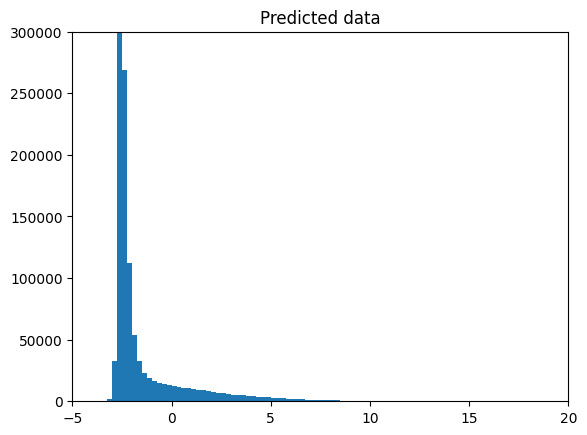

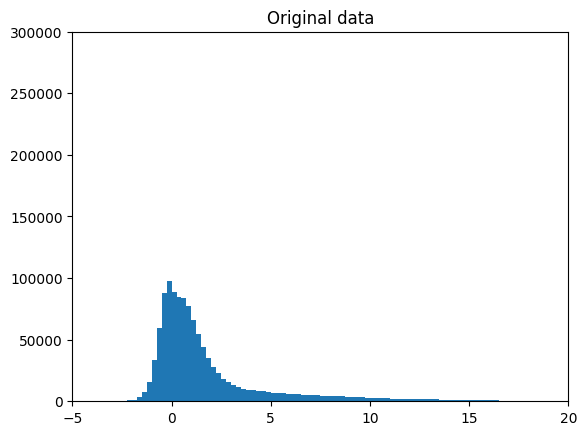

In [63]:
analyze_pred = 1
if analyze_pred:
    model_params = {}
    model_params['input_dim'] = trainer.train_loader.input_dim
    model_params['output_dim'] = trainer.train_loader.output_dim
    trainer.add_model(model, model_params)
    trainer.load_model(model_file)
    rna_pred, rna_orig = trainer.analyze_model(trainer.val_loader)
    #plot_model_analysis(rna_pred, rna_orig)

    plt.hist(rna_pred.flatten(), bins=100, range=(-5, 20))
    plt.title('Predicted data')
    plt.ylim((0, 300000))
    plt.xlim((-5, 20))
    plt.show()
    plt.hist(rna_orig.flatten(), bins=100, range=(-5, 20))
    plt.ylim((0, 300000))
    plt.xlim((-5, 20))
    plt.title('Original data')

## RUN LRRT

In [ ]:
def run_lrrt(train_loader, val_loader, batch_size=2048, end_lr=10, min_lr=1e-7, wd=2e-2, validation=False, device='cuda'):
    def criterion(predicted, orig):
        loss_fn = nn.MSELoss()
        l = loss_fn(orig, predicted[0])
        return l
    
    model_inst = model(train_loader.input_dim, train_loader.output_dim)
    optimizer = torch.optim.AdamW(model_inst.parameters(), lr=min_lr, weight_decay=wd)
    lr_finder = LRFinder(model_inst, optimizer, criterion, device=device)
    
    if validation:
        lr_finder.range_test(train_loader, end_lr=end_lr, num_iter=100, val_loader=val_loader)
    else:
        lr_finder.range_test(train_loader, end_lr=end_lr, num_iter=100)
        
    lr_finder.plot(log_lr=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.04E-03


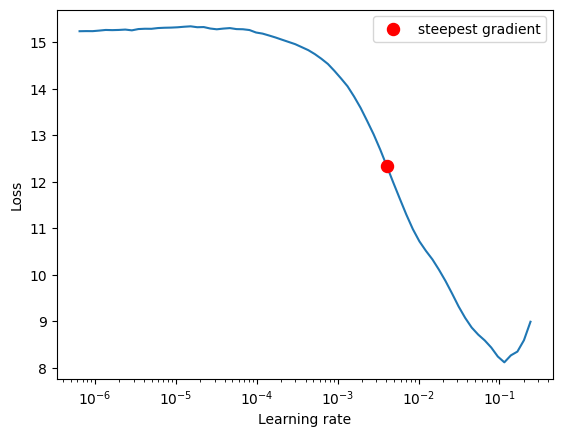

In [40]:
lrrt_on_train = 1
if lrrt_on_train:
    run_lrrt(train_loader, val_loader, end_lr=10)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.06E-04


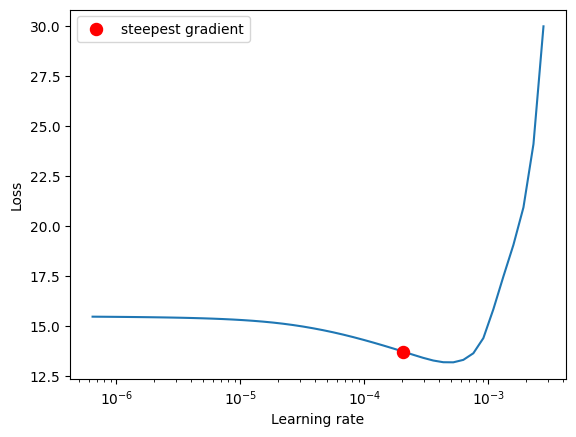

In [9]:
lrrt_on_val = 1
if lrrt_on_val:
    run_lrrt(train_loader, val_loader, validation=True)


## Make predictions

In [19]:
make_predictions = True
if make_predictions:
    model_params['input_dim'] = trainer.train_loader.input_dim
    model_params['output_dim'] = trainer.train_loader.output_dim
    trainer.add_model(model, model_params)
    trainer.load_model(model_file)
    
    
    outputs = trainer.transform(test_loader)

    with open(pred_file, 'wb') as f:
        np.save(f, outputs)